# Compute several characteristics of a detector network with respect to a skypoint

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pyburst as pb
import pyburst.detectors, pyburst.skymaps, pyburst.utils

### Plotting defaults

In [2]:
#%matplotlib notebook

plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['figure.titlesize'] = 'medium'

### Define network

In [3]:
detector_names = ['H1', 'L1', 'V1']
detectors = [pb.detectors.Detector(d) for d in detector_names]

### Define skymap object

In [4]:
coordsystem = pyburst.skymaps.Coordsystem("geographic")
NSIDE = 2**6
skymap = pyburst.skymaps.Skymap(NSIDE, coordsystem)

### Compute network plane

In [5]:
network_plane = np.array([detectors[2].location-detectors[0].location, \
                                 detectors[1].location-detectors[0].location])

network_plane_basis,_,_ = np.linalg.svd(network_plane.T)

### Define injection point

In [6]:
phi = 80*np.pi/180
injection_point = pb.skymaps.Skypoint.from_cart(network_plane_basis[:,0] * math.cos(phi) + \
                                               network_plane_basis[:,2] * math.sin(phi), coordsystem, 'injection')

### Computing mirror point, iso-delay circles and detector plane points

In [7]:
mirror_point = injection_point.mirror(detectors)

In [8]:
isodelay_LH = injection_point.isodelays(detectors[:2], 50)
isodelay_HV = injection_point.isodelays(detectors[1:], 50)
isodelay_LV = injection_point.isodelays([detectors[0],detectors[2]], 50)

In [9]:
pts_in_network_plane = []
for phi in np.linspace(0, 2*math.pi, 50):
    pts_in_network_plane.append(pb.skymaps.Skypoint.from_cart(network_plane_basis[:,0] * math.cos(phi) + \
                                               network_plane_basis[:,1] * math.sin(phi), coordsystem))

### Computing angle between $[F_+,F_\times]$ planes compared to the injection point

In [10]:
antenna_pattern = np.array([d.antenna_pattern(injection_point) for d in detectors])
normal_plane = np.cross(antenna_pattern[:,0],antenna_pattern[:,1])

angle_between_planes = []
for s in skymap.grid_points():
    
    current_antenna_pattern = np.array([d.antenna_pattern(s) for d in detectors])

    current_normal_plane = np.cross(current_antenna_pattern[:,0],current_antenna_pattern[:,1])
        
    angle_between_planes.append(np.degrees(pb.utils.angle_between(normal_plane,current_normal_plane)))
    
angle_between_planes = np.array(angle_between_planes)

# compute distance to 0 or to 180 deg
angle_between_planes = np.piecewise(angle_between_planes, [angle_between_planes <= 90, angle_between_planes > 90], [lambda x: x, lambda x: 180-x])

### Computing angle between $f_+$ compared to the injection point

In [11]:
antenna_pattern = np.array([d.antenna_pattern(injection_point) for d in detectors])
phi = np.arctan2(2*(antenna_pattern[:,0]@antenna_pattern[:,1]),
                 np.subtract(*np.linalg.norm(antenna_pattern, axis=0)**2))
psi = phi/4
c, s = np.cos(-2*psi), np.sin(-2*psi)
R = np.array(((c, s), (-s, c)))
antenna_pattern = antenna_pattern @ R

antenna_patterns = np.moveaxis(np.array([d.antenna_pattern(skymap.grid_points()) 
                                         for d in detectors]),
                               2,0)
for F in antenna_patterns:
    phi = np.arctan2(2*(F[:,0]@F[:,1]),
                     np.subtract(*np.linalg.norm(F, axis=0)**2))
    psi = phi/4
    c, s = np.cos(-2*psi), np.sin(-2*psi)
    R = np.array(((c, s), (-s, c)))
    F = F @ R

angle_between_dominant_polar = []
for F in antenna_patterns:
    angle_between_dominant_polar.append(np.degrees(pb.utils.angle_between(antenna_pattern[:,0],F[:,0])))
angle_between_dominant_polar = np.array(angle_between_dominant_polar)

# compute distance to 0 or to 180 deg
angle_between_dominant_polar = np.piecewise(angle_between_dominant_polar, [angle_between_dominant_polar <= 90, angle_between_dominant_polar > 90], [lambda x: x, lambda x: 180-x])

### Plot

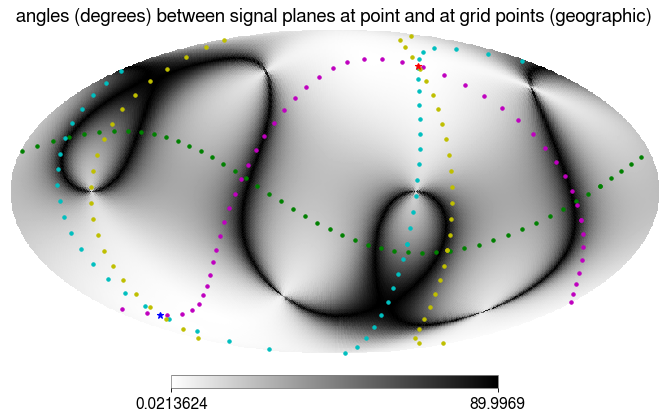

In [12]:
skymap.feed(angle_between_planes)
skymap.display("angles (degrees) between signal planes at point and at grid points")
#for point in pts_in_network_plane:
#    point.display('.','g')
for point in isodelay_LH:
    point.display('.', 'm')
for point in isodelay_HV:
    point.display('.', 'c')
for point in isodelay_LV:
    point.display('.', 'y')
injection_point.display('*', 'r')
mirror_point.display('*', 'b')
plt.show()

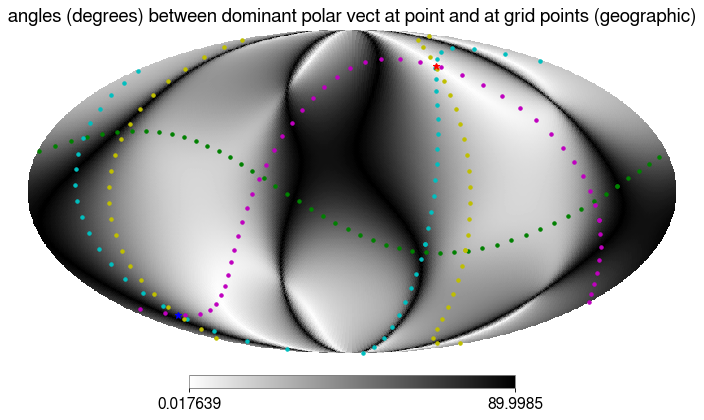

In [13]:
skymap.feed(angle_between_dominant_polar)
skymap.display("angles (degrees) between dominant polar vect at point and at grid points")
#for point in pts_in_network_plane:
#    point.display('.','g')
for point in isodelay_LH:
    point.display('.', 'm')
for point in isodelay_HV:
    point.display('.', 'c')
for point in isodelay_LV:
    point.display('.', 'y')
injection_point.display('*', 'r')
mirror_point.display('*', 'b')
plt.show()

### Coordinates for simulation

In [14]:
injection_time = 1186741856.0
new_coordsystem = pyburst.skymaps.Coordsystem("equatorial", injection_time)
injection_point.transformed_to(new_coordsystem).coords('lonlat', 'degrees')

[47.37422977528988, 61.36854762263558]